In [1]:
!pwd

/home/giakhang/dev/RDPN6D


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import trimesh
import cv2

from detectron2.config import LazyConfig, instantiate
from detectron2.data import MetadataCatalog, get_detection_dataset_dicts

from core.gdrn_modeling.dataset_factory import register_datasets_in_cfg
from core.utils.draw_utils import *

/home/giakhang/miniconda3/envs/rdpn6d/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [3]:
cad_path = "./datasets/lumi_piano_dataset/models/obj_000001.ply"

mesh = trimesh.load_mesh(cad_path)
mesh = mesh.sample(1024).astype(np.float32)

In [4]:
cfg_fp = "./configs/gdrn/a6_cPnP.py"

cfg = LazyConfig.load(cfg_fp)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [5]:
register_datasets_in_cfg(cfg)

[0328_192700@core/gdrn_modeling/datasets/lumi_piano.py:357] DBG register dataset: lumi_piano_train
[0328_192700@core/gdrn_modeling/datasets/lumi_piano.py:357] DBG register dataset: lumi_piano_test
[0328_192700@core/gdrn_modeling/datasets/syn_lumi_piano.py:343] DBG register dataset: syn_lumi_piano_train


# Plot train set

In [6]:
train_loader = instantiate(cfg.dataloader.train)  

In [7]:
train_loader_iter = iter(train_loader)

In [8]:
data = next(train_loader_iter)

In [9]:
import torch
import numpy as np
import itertools


def batch_data(data, device="cuda", phase="train"):
    if phase != "train":
        return batch_data_test(data, device=device)

    # batch training data
    batch = {}
    batch["roi_img"] = torch.stack([d["roi_img"] for d in data], dim=0).to(device, non_blocking=True)
    batch["fps"] = torch.stack([d["fps"] for d in data], dim=0).to(
        device=device, dtype=torch.float32, non_blocking=True
    )
    batch["roi_cls"] = torch.tensor([d["roi_cls"] for d in data], dtype=torch.long).to(device, non_blocking=True)
    if "roi_coord_2d" in data[0]:
        batch["roi_coord_2d"] = torch.stack([d["roi_coord_2d"] for d in data], dim=0).to(
            device=device, non_blocking=True
        )

    batch["roi_cam"] = torch.stack([d["cam"] for d in data], dim=0).to(device, non_blocking=True)
    batch["trans_mat"] = torch.stack([d["trans_mat"] for d in data], dim=0).to(device, non_blocking=True) 
    batch["roi_center"] = torch.stack([d["bbox_center"] for d in data], dim=0).to(
        device=device, dtype=torch.float32, non_blocking=True
    )
    batch["roi_wh"] = torch.stack([d["roi_wh"] for d in data], dim=0).to(device, non_blocking=True)
    batch["resize_ratio"] = torch.tensor([d["resize_ratio"] for d in data]).to(
        device=device, dtype=torch.float32, non_blocking=True
    )
    batch["roi_extent"] = torch.stack([d["roi_extent"] for d in data], dim=0).to(
        device=device, dtype=torch.float32, non_blocking=True
    )

    batch["roi_trans_ratio"] = torch.stack([d["trans_ratio"] for d in data], dim=0).to(device, non_blocking=True)
    # yapf: disable
    for key in [
        "roi_xyz",
        "roi_xyz_bin",
        "roi_mask_trunc",
        "roi_mask_visib",
        "roi_mask_obj",
        "roi_region",
        "ego_quat",
        "allo_quat",
        "ego_rot6d",
        "allo_rot6d",
        "ego_rot",
        "trans",
        "roi_points",
    ]:
        if key in data[0]:
            if key in ["roi_region"]:
                dtype = torch.long
            else:
                dtype = torch.float32
            batch[key] = torch.stack([d[key] for d in data], dim=0).to(
                device=device, dtype=dtype, non_blocking=True
            )
    # yapf: enable
    if "sym_info" in data[0]:
        batch["sym_info"] = [d["sym_info"] for d in data]

    return batch


def batch_data_test(data, device="cuda"):
    batch = {}
    if not isinstance(data, list):  # bs = 1
        data = [data]
    # yapf: disable
    roi_keys = ["im_H", "im_W",
                "roi_img", "inst_id", "roi_coord_2d", "roi_cls", "score", "roi_extent",
                "bbox", "bbox_est", "bbox_mode", "roi_wh",
                "scale", "resize_ratio",
                ]
    for key in roi_keys:
        if key in ["roi_cls"]:
            dtype = torch.long
        else:
            dtype = torch.float32
        if key in data[0]:
            batch[key] = torch.cat([d[key] for d in data], dim=0).to(device=device, dtype=dtype, non_blocking=True)
    # yapf: enable

    batch["trans_mat"] = torch.stack([d["trans_mat"] for d in data], dim=0).to(device, non_blocking=True) 
    batch["roi_cam"] = torch.cat([d["cam"] for d in data], dim=0).to(device, non_blocking=True)
    batch["roi_center"] = torch.cat([d["bbox_center"] for d in data], dim=0).to(device, non_blocking=True)
    batch["roi_xyz"] = torch.stack([d["roi_xyz"] for d in data], dim=0).to(
                device=device, dtype=dtype, non_blocking=True
            )
    batch["fps"] = torch.stack([d["fps"] for d in data], dim=0).to(
        device=device, dtype=torch.float32, non_blocking=True
    )
    batch["fps"] = torch.squeeze(batch["fps"],0)
    for key in ["scene_im_id", "file_name", "model_info"]:
        # flatten the lists
        if key in data[0]:
            batch[key] = list(itertools.chain(*[d[key] for d in data]))

    return batch

In [10]:
batch = batch_data(data)

In [11]:
roi_img = batch["roi_img"][0].to('cpu').permute(1, 2, 0).numpy()[..., :3][..., ::-1]
roi_K = batch['roi_cam'][0].to('cpu').numpy()
rot = batch['ego_rot'][0].to('cpu').numpy()
trans = batch['trans'][0].to('cpu').numpy()
trans_mat = batch['trans_mat'][0].to('cpu').numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


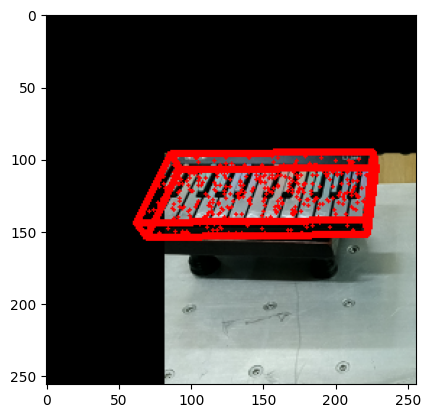

In [12]:
vis_img = draw_detections(roi_img, rot[None, ...], trans[None, ...]*1000, mesh*1000, (trans_mat@roi_K)[None, ...])

plt.imshow(vis_img)

In [13]:
data

[{'inst_id': 0,
  'dataset_name': 'lumi_piano_train',
  'file_name': 'datasets/lumi_piano_dataset/data/track_07/rgb/00194.png',
  'depth_file': 'datasets/lumi_piano_dataset/data/track_07/depth/00194.png',
  'image_id': 194,
  'scene_im_id': '7/194',
  'cam': tensor([[591.2213,   0.0000, 320.0000],
          [  0.0000, 591.2213, 200.0000],
          [  0.0000,   0.0000,   1.0000]]),
  'img_type': 'real',
  'width': 640,
  'height': 400,
  'roi_cls': 0,
  'roi_extent': tensor([0.2824, 0.0258, 0.1412]),
  'trans_mat': tensor([[ 6.0423e-01, -5.7192e-17,  8.1982e+01],
          [-0.0000e+00,  6.0423e-01,  9.6160e+01],
          [ 0.0000e+00,  0.0000e+00,  1.0000e+00]], dtype=torch.float64),
  'roi_region': tensor([[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32),
  'roi_xyz': tensor([[[ 0.4332,  0.4332

In [14]:
img = cv2.imread(data[0]['file_name'])[..., ::-1]
rot = data[0]['ego_rot'].to('cpu').numpy()
trans = data[0]['trans'].to('cpu').numpy()
K = data[0]['cam'].to('cpu').numpy()

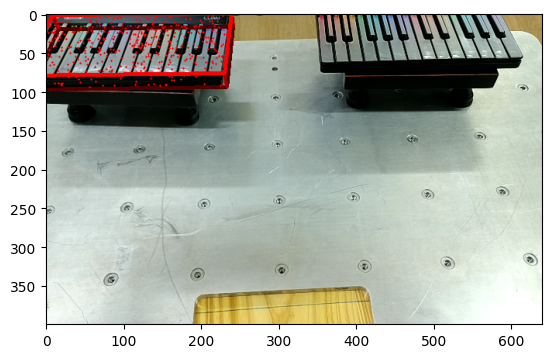

In [15]:
vis_img = draw_detections(img, rot[None, ...], trans[None, ...]*1000, mesh*1000, K[None, ...])

plt.imshow(vis_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


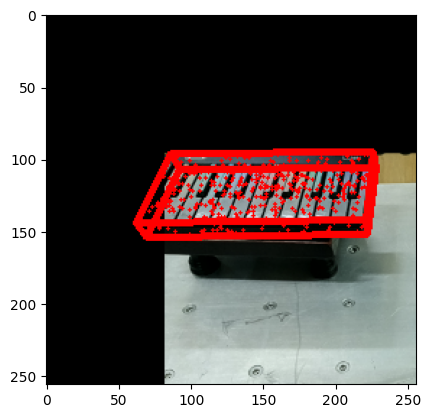

In [16]:
roi_img = data[0]['roi_img'].to('cpu').permute(1, 2, 0).numpy()[..., :3][..., ::-1]
trans_mat = data[0]['trans_mat'].to('cpu').numpy()


vis_img = draw_detections(roi_img, rot[None, ...], trans[None, ...]*1000, mesh*1000, (trans_mat @ K)[None, ...])

plt.imshow(vis_img)

# Plot test set

In [17]:
test_loader = instantiate(cfg.dataloader.test)
test_loader_iter = iter(test_loader)
data = next(test_loader_iter)

In [18]:
test_batch = batch_data(data, phase="test")

In [19]:
test_batch

{'im_H': tensor([400.], device='cuda:0'),
 'im_W': tensor([640.], device='cuda:0'),
 'roi_img': tensor([[[[ 0.0000e+00,  3.9216e-03,  0.0000e+00,  ...,  6.6667e-02,
             5.4902e-02,  5.4902e-02],
           [ 3.9216e-03,  0.0000e+00,  0.0000e+00,  ...,  5.4902e-02,
             5.8824e-02,  4.7059e-02],
           [ 3.9216e-03,  3.9216e-03,  0.0000e+00,  ...,  5.0980e-02,
             5.0980e-02,  5.0980e-02],
           ...,
           [ 9.8039e-02,  9.8039e-02,  9.8039e-02,  ...,  3.1373e-02,
             2.3529e-02,  2.7451e-02],
           [ 1.2157e-01,  1.2941e-01,  1.1373e-01,  ...,  1.9608e-02,
             1.5686e-02,  2.3529e-02],
           [ 1.2157e-01,  1.1765e-01,  1.1765e-01,  ...,  2.3529e-02,
             1.5686e-02,  1.5686e-02]],
 
          [[ 1.4118e-01,  1.4902e-01,  1.4510e-01,  ...,  2.2353e-01,
             2.0784e-01,  2.0000e-01],
           [ 1.4118e-01,  1.4510e-01,  1.4118e-01,  ...,  2.1176e-01,
             2.0392e-01,  1.9216e-01],
           [ 1

In [20]:
data

[{'dataset_name': 'lumi_piano_test',
  'file_name': ['datasets/lumi_piano_dataset/data/track_01/rgb/00007.png'],
  'depth_file': 'datasets/lumi_piano_dataset/data/track_01/depth/00007.png',
  'image_id': 7,
  'scene_im_id': ['1/7'],
  'cam': tensor([[[584.7296,   0.0000, 320.0000],
           [  0.0000, 584.7296, 200.0000],
           [  0.0000,   0.0000,   1.0000]]]),
  'img_type': 'real',
  'annotations': [{'category_id': 0,
    'bbox': [190, 158, 247, 99],
    'bbox_mode': <BoxMode.XYWH_ABS: 1>,
    'pose': array([[-0.9735539 ,  0.22362763,  0.04672926, -0.00559846],
           [-0.22758159, -0.9314196 , -0.28401455,  0.00750756],
           [-0.01998899, -0.2871382 ,  0.9576806 ,  0.7552521 ]],
          dtype=float32),
    'quat': array([ 0.11479025, -0.00680288,  0.14530459, -0.9826818 ], dtype=float32),
    'trans': array([-0.00559846,  0.00750756,  0.7552521 ], dtype=float32),
    'centroid_2d': array([315.66556, 205.8125 ], dtype=float32),
    'segmentation': {'size': [400, 64

In [21]:
img = cv2.imread(data[0]['file_name'][0])[..., ::-1]
rot = data[0]['annotations'][0]['pose'][:, :-1]
trans = data[0]['annotations'][0]['trans']
K = data[0]['cam'][0].to('cpu').numpy()

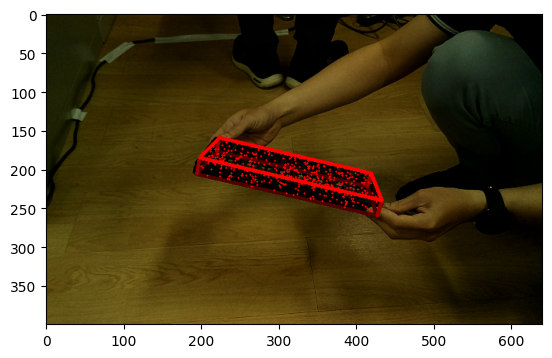

In [22]:
vis_img = draw_detections(img, rot[None, ...], trans[None, ...]*1000, mesh*1000, K[None, ...])

plt.imshow(vis_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


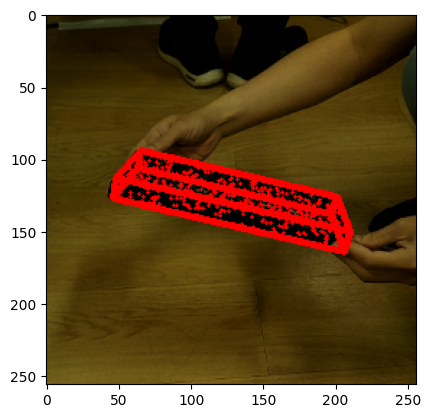

In [23]:
roi_img = data[0]['roi_img'].to('cpu')[0].permute(1, 2, 0).numpy()[..., :3][..., ::-1]
trans_mat = data[0]['trans_mat'].to('cpu').numpy()


vis_img = draw_detections(roi_img, rot[None, ...], trans[None, ...]*1000, mesh*1000, (trans_mat @ K)[None, ...])

plt.imshow(vis_img)

# Syn data

In [24]:
syn_train_loader = instantiate(cfg.dataloader.train2) 
syn_train_loader_iter = iter(syn_train_loader)
syn_data = next(syn_train_loader_iter) 

In [25]:
syn_batch = batch_data(syn_data)

In [26]:
roi_img = syn_batch["roi_img"][0].to('cpu').permute(1, 2, 0).numpy()[..., :3][..., ::-1]
roi_K = syn_batch['roi_cam'][0].to('cpu').numpy()
rot = syn_batch['ego_rot'][0].to('cpu').numpy()
trans = syn_batch['trans'][0].to('cpu').numpy()
trans_mat = syn_batch['trans_mat'][0].to('cpu').numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


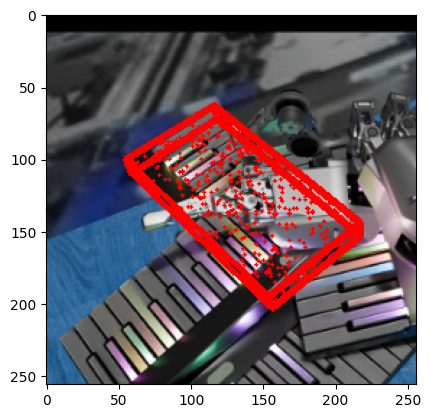

In [27]:
vis_img = draw_detections(roi_img, rot[None, ...], trans[None, ...]*1000, mesh*1000, (trans_mat@roi_K)[None, ...])

plt.imshow(vis_img)

In [28]:
img = cv2.imread(syn_data[0]['file_name'])[..., ::-1]
rot = syn_data[0]['ego_rot'].to('cpu').numpy()
trans = syn_data[0]['trans'].to('cpu').numpy()
K = syn_data[0]['cam'].to('cpu').numpy()

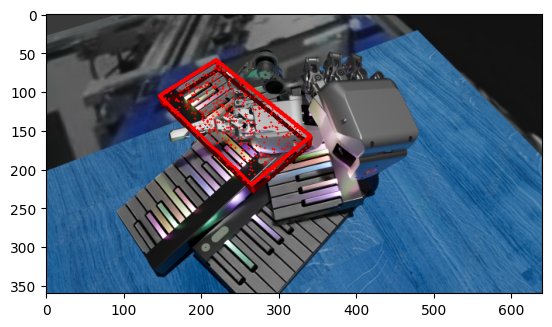

In [29]:
vis_img = draw_detections(img, rot[None, ...], trans[None, ...]*1000, mesh*1000, K[None, ...])

plt.imshow(vis_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


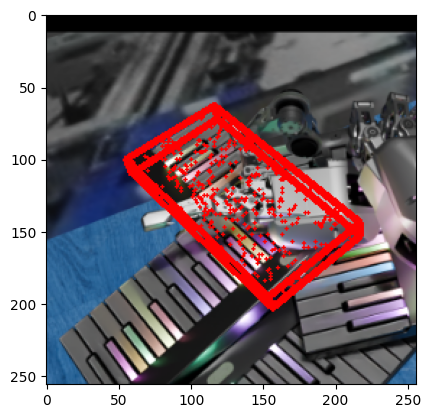

In [30]:
roi_img = syn_data[0]['roi_img'].to('cpu').permute(1, 2, 0).numpy()[..., :3][..., ::-1]
trans_mat = syn_data[0]['trans_mat'].to('cpu').numpy()


vis_img = draw_detections(roi_img, rot[None, ...], trans[None, ...]*1000, mesh*1000, (trans_mat @ K)[None, ...])

plt.imshow(vis_img)

In [31]:
evaluator = instantiate(cfg.dataloader.evaluator)